In [1]:
from leicaexperiment import Experiment
e = Experiment('data/experiment--2015_03_21_17_09_56 kopi')

In [2]:
rows = e.rows(0,0)
cols = e.columns(0,0)
rows, cols

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [3]:
import numpy as np

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# monkey patch - faster fft
import numpy.fft
import pyfftw.interfaces.numpy_fft
numpy.fft = pyfftw.interfaces.numpy_fft

In [6]:
from skimage import io
from skimage.feature import register_translation

In [7]:
# check monkey patch
from skimage.feature.register_translation import np as rtnp
rtnp.fft

<module 'pyfftw.interfaces.numpy_fft' from '/Users/arve/.virtualenvs/3.4/lib/python3.4/site-packages/pyfftw/interfaces/numpy_fft.py'>

# equalize images for improved high frequency patterns

In [8]:
def img_hist(img):
    if type(img) == str:
        img = io.imread(img)
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    io.imshow(img)
    plt.subplot(122)
    plt.hist(img.flatten())

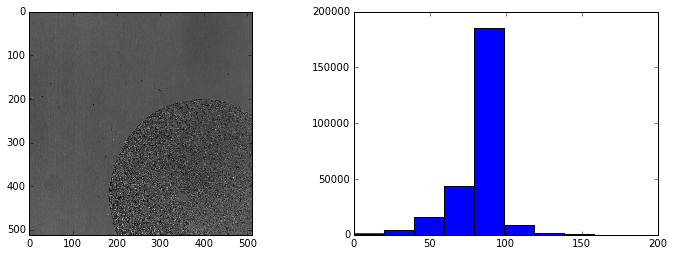

In [9]:
img_hist(e.image(0,0,0,0))

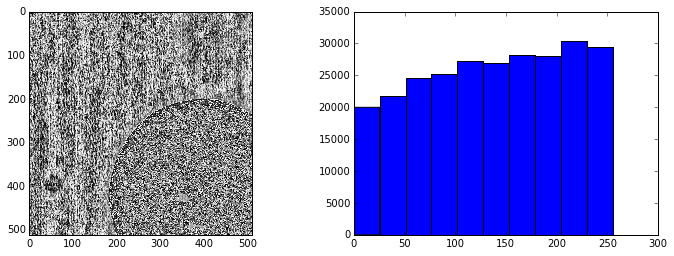

In [10]:
from skimage import filters, morphology
img = io.imread(e.image(0,0,0,0))
selem = morphology.square(51)
eq = filters.rank.equalize(img, selem)
img_hist(eq)

In [235]:
img1 = io.imread(e.image(0,0,0,0))
img2 = io.imread(e.image(0,0,1,0))

In [12]:
from skimage import feature

In [118]:
res = feature.match_template(img1, img2[:,:10])
np.argmax(res)

454

In [119]:
454-512

-58

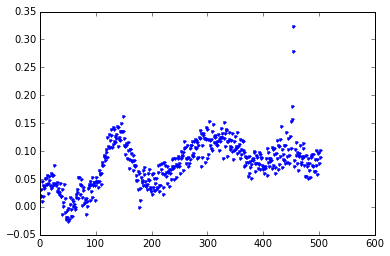

In [120]:
plt.plot(res[0,:], '.')

In [238]:
def x_registration(img1, img2):
    res1 = feature.match_template(img1[:,256+128+64:], img2[:,:20])
    res2 = feature.match_template(img1[:,256+128+64:], img2[:,:40])
    x1 = np.argmax(res1)+256+128+64
    x2 = np.argmax(res2)+256+128+64
    # return 0 for y position
    return 0, (x1+x2)/2-img1.shape[0]

In [242]:
%time x_registration(img1, img2)

CPU times: user 103 ms, sys: 35.2 ms, total: 139 ms
Wall time: 141 ms


(0, -58.0)

In [243]:
%time feature.register_translation(img1, img2)

CPU times: user 58 ms, sys: 27.4 ms, total: 85.4 ms
Wall time: 85.6 ms


(array([  0., -58.]), 0.23385038883212236, -8.3512070072224745e-20)

# find translation with image registration

In [246]:
%%time
translations = []
row = 0
selem = morphology.square(255)
prev_p = None
for col in cols:
    p = e.image(0, 0, col, row)
    if prev_p:
        img1 = io.imread(prev_p)
        img2 = io.imread(p)

        # improve high frequency signal
        #img1 = filters.rank.equalize(img1, selem)
        #img2 = filters.rank.equalize(img2, selem)

        #pos,err,phase_diff = register_translation(img1, img2, upsample_factor=10)
        pos = x_registration(img1, img2)
        translations.append((pos[0], pos[1], row, col))
    prev_p = p

CPU times: user 2.28 s, sys: 650 ms, total: 2.93 s
Wall time: 2.94 s


In [247]:
# so that we can use index notation
translations = np.array(translations)

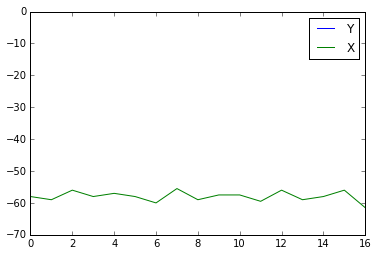

In [248]:
plt.plot(translations[:,0])
plt.plot(translations[:,1])
plt.legend(('Y', 'X'), loc='best');

In [249]:
translations[:,1], translations[:,3]

(array([-58. , -59. , -56. , -58. , -57. , -58. , -60. , -55.5, -59. ,
        -57.5, -57.5, -59.5, -56. , -59. , -58. , -56. , -61.5]),
 array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.]))

In [250]:
np.median(translations[:,1]), np.std(translations[:,1])

(-58.0, 1.5574355641027915)

# removing outliers

In [251]:
def find_outliers(data, m=2):
    return abs(data - np.mean(data)) > m * np.std(data)

In [252]:
find_outliers(translations[:,1])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True], dtype=bool)

In [253]:
np.any(find_outliers(translations[:,1]))

True

In [254]:
def cancel_outliers(data):
    outliers = find_outliers(data)
    while np.any(outliers):
        data[outliers] = np.mean(data)
        outliers = find_outliers(data)
    # data changed in place, return anyhow
    return data

In [255]:
cancel_outliers(translations[:,1])

array([-58.        , -59.        , -56.        , -58.        ,
       -57.        , -58.        , -60.        , -55.5       ,
       -59.        , -57.5       , -57.5       , -59.5       ,
       -56.        , -59.        , -58.        , -56.        , -57.97058824])

In [256]:
np.std(translations[:,1]), np.mean(translations[:,1]), np.median(translations[:,1])

(1.2844270149727095, -57.762975778546718, -58.0)

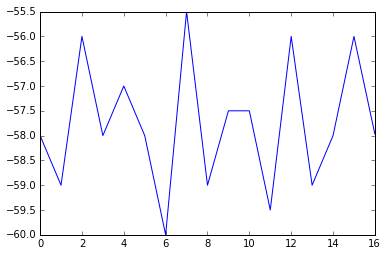

In [257]:
plt.plot(translations[:,1])

# might use curve fit also

In [188]:
from scipy.optimize import curve_fit

In [189]:
def line(x,a,b):
    return a*x+b

In [190]:
fit, covariance = curve_fit(line, translations[:,3], translations[:,1])
fit

array([  2.68632539e-02,  -5.79132531e+01])

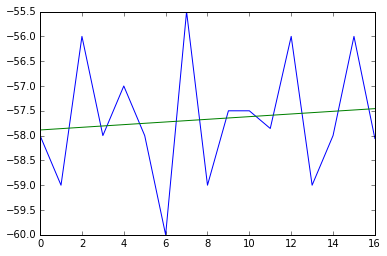

In [191]:
plt.plot(translations[:,1])
plt.plot(translations[:,3]*fit[0]+fit[1])

# merge with variable offset

In [258]:
width = 512*len(cols) + int(translations[:,1].sum())
width

8235

In [259]:
merged = np.zeros((512, width), dtype=np.uint8)

In [260]:
merged[:,0:512] = io.imread(e.image(0,0,0,0))
for col in cols[1:]:
    p = e.image(0,0,col,0)
    offset = translations[col-1,1] // 2 # half of each image
    start = 512*col + int(sum(translations[:col-1,1]) + offset)
    end = start + 512 + offset
    merged[:,start:end] = io.imread(p)[:,-offset:]

In [261]:
# zoom and look around
#%matplotlib qt

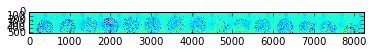

In [196]:
#plt.figure(figsize=(14,3))
plt.imshow(merged);

In [197]:
io.imsave(e.path + '/merged_row.png', merged)

# all translations

In [262]:
translations = []
for row in rows:
    prev_p = None
    for col in cols:
        p = e.image(0, 0, col, row)
        if prev_p:
            img1 = io.imread(prev_p)
            img2 = io.imread(p)
            #pos,err,ph = register_translation(img1, img2, upsample_factor=100)
            pos = x_registration(img1, img2)
            translations.append((pos[0], pos[1], row, col))
        prev_p = p
translations = np.array(translations)

In [263]:
%matplotlib inline

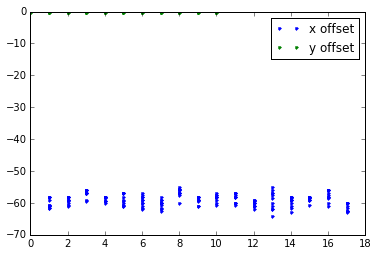

In [264]:
plt.plot(translations[:,3], translations[:,1], '.')
plt.plot(translations[:,2], translations[:,0], '.')
plt.legend(('x offset', 'y offset'));

In [265]:
np.std(translations[:,1]), np.var(translations[:,1])

(1.7803591936509484, 3.1696788584174556)

In [266]:
# sanitize data
cancel_outliers(translations[:,0])
cancel_outliers(translations[:,1]);

In [267]:
np.std(translations[:,1]), np.var(translations[:,1])

(1.4205378099927695, 2.0179276696190538)

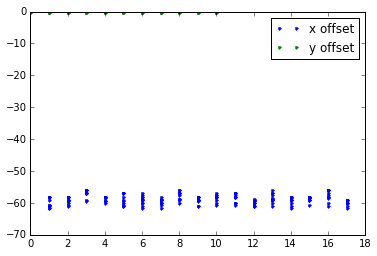

In [268]:
plt.plot(translations[:,3], translations[:,1], '.')
plt.plot(translations[:,2], translations[:,0], '.')
plt.legend(('x offset', 'y offset'));

In [269]:
np.mean(translations[:,1]), np.median(translations[:,1])

(-58.782034293781663, -58.935828877005349)

In [270]:
np.mean(translations[:,0]), np.median(translations[:,0])

(0.0, 0.0)

# merge rows - fixed offset

In [208]:
height = img1.shape[0]
single_width = img1.shape[1]

In [209]:
# column x
mask = translations[:,3] == 1
translations[mask][:,1], np.mean(translations[mask][:,1])

(array([-58.        , -58.        , -60.5       , -58.        ,
        -61.5       , -61.        , -59.06619561, -60.06504332,
        -61.        , -59.        , -60.5       ]), -59.693748993570011)

In [210]:
x_offsets = []
for col in cols[1:]:
    mask = translations[:,3] == col
    x_offsets.append(translations[mask][:,1].mean())
x_offsets.insert(0, 0) # first image

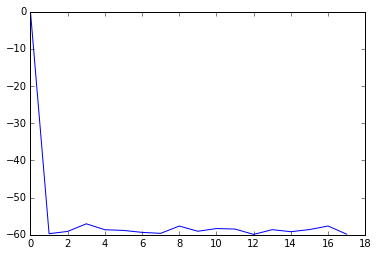

In [211]:
plt.plot(x_offsets);

In [212]:
width = single_width*len(cols) + int(sum(x_offsets))
width

8217

In [213]:
row_imgs = []
for row in rows:
    merged = np.zeros((height, width), dtype=np.uint8)
    for col in cols:
        p = e.image(0,0,col,row)
        offset = x_offsets[col] // 2 # half of each image
        start = single_width*col + int(sum(x_offsets[:col+1]) - offset)
        end = start + single_width + offset
        merged[:,start:end] = io.imread(p)[:,-offset:]
    row_imgs.append(merged)

# merge rows - variable offset

In [272]:
height = img1.shape[0]
single_width = img1.shape[1]

In [273]:
mask = translations[:,2] == 2
translations[mask][:,1], translations[mask][:,1].sum()

(array([-60.5       , -61.        , -57.        , -60.        ,
        -60.5       , -61.        , -58.83113615, -56.        ,
        -59.        , -59.        , -60.        , -60.        ,
        -61.        , -60.        , -58.5       , -56.        , -58.93582888]),
 -1007.266965026166)

In [274]:
row_imgs = []
for row in rows:
    x_offsets = translations[translations[:,2] == row][:,1]
    width = single_width*len(cols) + int(x_offsets.sum())
    merged = np.zeros((height, width), dtype=np.uint8)
    for col in cols:
        p = e.image(0,0,col,row)
        offset = x_offsets[col-1] // 2 # half of each image
        start = single_width*col + int(sum(x_offsets[:col-1]) + offset)
        if col == 0:
            offset = 0
            start = 0
        end = start + single_width + offset
        merged[:,start:end] = io.imread(p)[:,-offset:]
    row_imgs.append(merged)

In [275]:
def same_size(*arrays):
    ys = [arr.shape[0] for arr in arrays]
    xs = [arr.shape[1] for arr in arrays]
    y = max(ys)
    x = max(xs)
    res = []
    for arr in arrays:
        new_arr = np.zeros((y,x), dtype=arr.dtype)
        cy,cx = arr.shape
        new_arr[:cy, :cx] = arr
        res.append(new_arr)
    return res

In [276]:
row_imgs = same_size(*row_imgs)

In [277]:
%time register_translation(row_imgs[0], row_imgs[1], upsample_factor=100)

KeyboardInterrupt: 

In [93]:
%time register_translation(row_imgs[0], row_imgs[1], upsample_factor=10)

CPU times: user 1.49 s, sys: 230 ms, total: 1.72 s
Wall time: 1.67 s


(array([-58.6,  -0.5]), 0.22162371036060383, 7.6502774115025229e-08)

In [92]:
%time register_translation(row_imgs[0], row_imgs[1], upsample_factor=1)

CPU times: user 1.41 s, sys: 231 ms, total: 1.64 s
Wall time: 1.64 s


(array([-59.,  -1.]), 0.22308637129800798, 1.3853430333797005e-19)

# find row translations

In [278]:
prev_img = None
row_translations = []
for img in row_imgs:
    if prev_img != None:
        row_translations.append(register_translation(prev_img, img, upsample_factor=100))
    prev_img = img
row_translations

/Users/arve/.virtualenvs/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


[(array([-58.81,   5.61]), 0.22458862552759984, 5.8435084805442543e-07),
 (array([-59.1 ,  12.69]), 0.21772465888857309, -1.6044164240717162e-07),
 (array([-56.13,  -5.56]), 0.21069094014881967, 3.2697713390736351e-07),
 (array([ -1.74, -10.15]), 0.22143573475938591, -2.0078775876523628e-07),
 (array([-22.68,   3.83]), 0.22045185166187659, 5.8675051684714985e-08),
 (array([-56.94,   3.58]), 0.20593609094334811, -5.8941221392015873e-08),
 (array([-58.53,   1.28]), 0.18499292935692646, -4.7350159012450681e-08),
 (array([-56.99,   0.97]), 0.177605640491484, -1.5480226721211762e-09),
 (array([-59.99,   8.11]), 0.17463984039146155, 4.01548528664166e-09),
 (array([-56.79, -12.17]), 0.18200594283829599, 4.6056387684022932e-08)]

In [279]:
row_offsets = np.array([[t[0][0], t[0][1]] for t in row_translations])

In [280]:
min_x = row_offsets[:,1].min()
row_offsets[:,1] -= min_x # minimum at position zero

In [281]:
row_offsets[:,0], row_offsets[:,1]

(array([-58.81, -59.1 , -56.13,  -1.74, -22.68, -56.94, -58.53, -56.99,
        -59.99, -56.79]),
 array([ 17.78,  24.86,   6.61,   2.02,  16.  ,  15.75,  13.45,  13.14,
         20.28,   0.  ]))

In [282]:
cancel_outliers(row_offsets[:,0])

array([-58.81   , -59.1    , -56.13   , -56.5523 , -57.33053, -56.94   ,
       -58.53   , -56.99   , -59.99   , -56.79   ])

In [283]:
# add position of first row
all_row_offsets = np.concatenate(([[0,-min_x]], row_offsets))

In [284]:
all_row_offsets

array([[  0.     ,  12.17   ],
       [-58.81   ,  17.78   ],
       [-59.1    ,  24.86   ],
       [-56.13   ,   6.61   ],
       [-56.5523 ,   2.02   ],
       [-57.33053,  16.     ],
       [-56.94   ,  15.75   ],
       [-58.53   ,  13.45   ],
       [-56.99   ,  13.14   ],
       [-59.99   ,  20.28   ],
       [-56.79   ,   0.     ]])

# merge row with variable offset

In [285]:
# use calculated offsets
y_offsets = all_row_offsets[:,0]
x_offsets = all_row_offsets[:,1]
single_height = row_imgs[0].shape[0]
width = row_imgs[0].shape[1]
height = len(rows)*single_height + int(sum(y_offsets))
height, width

(5055, 8228)

In [286]:
merged = np.zeros((height, width), dtype=np.uint8)
for row,img in enumerate(row_imgs):
    x_start = int(x_offsets[row])
    # roll destination array (as row_imgs are padded with zeros)
    merged = np.roll(merged, -x_start, axis=1)
    offset = y_offsets[row] // 2
    start = single_height*row + int(sum(y_offsets[:row+1]) - offset)
    end = start + single_height + offset
    merged[start:end,:] = img[-offset:,:]
    # roll back
    merged = np.roll(merged, x_start, axis=1)

In [179]:
%matplotlib qt

In [180]:
io.imshow(merged, interpolation='none')

In [287]:
io.imsave(e.path + '/stitched-registration-equalized.png', merged)

In [64]:
%qtconsole